MNIST TensorFlow solution with LeNet5 like network, learning rate decay, dropout and data augmentation.

In [1]:
import numpy as np
import pandas as pd
import math

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

In [3]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')

Separate labels from *train_data*

In [4]:
digit_labels = train_data["label"]
train_data = train_data.drop(labels = ["label"], axis = 1)

Convert labels to one-hot vector

In [5]:
Y = (np.arange(num_labels) == digit_labels[:,None]).astype(np.float32)

In [6]:
print(digit_labels.shape)
print(Y.shape)

(42000,)
(42000, 10)


Reshape train and test data to image like shape. It allows using convolutions.

In [7]:
X = train_data.values.reshape(-1, image_size, image_size, num_channels).astype(np.float32)
X_test = test_data.values.reshape(-1, image_size, image_size, num_channels).astype(np.float32)

Normalize train and test data

In [8]:
X = X / 255.0
X_test = X_test / 255.0

Plot some images with the lables (titles)

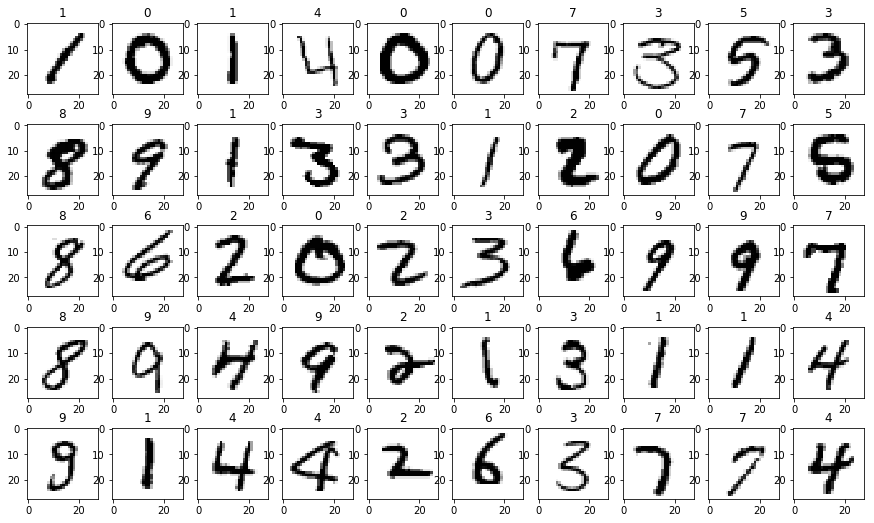

In [9]:
plt.figure(figsize=(15,9))
for i in range(50):
    plt.subplot(5,10,1+i)
    plt.title(digit_labels[i])
    plt.imshow(X[i].reshape(28,28), cmap=cm.binary)

Data augmentation by using rotation, shear, shift and zoom.

In [10]:
def augment_images(data, labels, copies = 1, rotation=True, shear=True, shift=True, zoom=True):
    augmented_data = []
    augmented_labels = []
    
    for i in range (0, labels.shape[0]):
        augmented_data.append(data[i])
        augmented_labels.append(labels[i])
        
        for j in range(1, copies):            
            img = data[i]
            lbl = labels[i]
                        
            if (rotation):
                img = tf.contrib.keras.preprocessing.image.random_rotation(img, 15, row_axis=0, col_axis=1, channel_axis=2)
            if (shear):
                img = tf.contrib.keras.preprocessing.image.random_shear(img, 0.1, row_axis=0, col_axis=1, channel_axis=2)
            if (shift):
                img = tf.contrib.keras.preprocessing.image.random_shift(img, 0.15, 0.15, row_axis=0, col_axis=1, channel_axis=2)
            if (zoom):
                img = tf.contrib.keras.preprocessing.image.random_zoom(img, (0.9, 1.1), row_axis=0, col_axis=1, channel_axis=2)
            
            augmented_data.append(img)
            augmented_labels.append(lbl)
    
    return np.array(augmented_data), np.array(augmented_labels)

To tune augmentation parameters (like rotation angle) plot some images and their augmented copies.


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



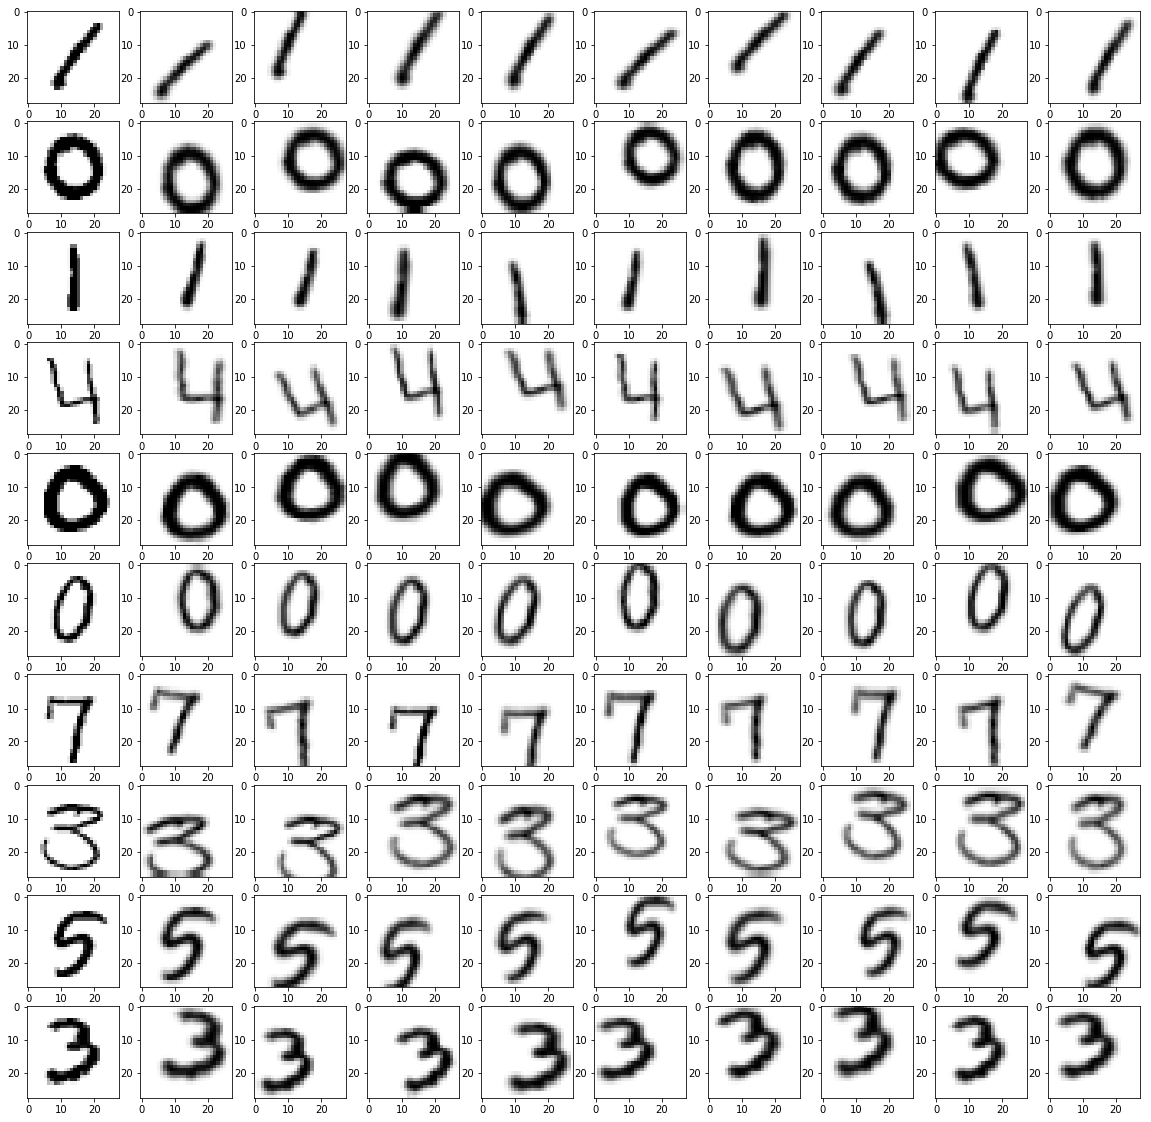

In [11]:
x = X[:10]
y = Y[:10]

x, y = augment_images(x, y, copies=10)

plt.figure(figsize=(20,20))
for i in range(len(x)):
    plt.subplot(10,10,1+i)
    plt.imshow(x[i].reshape(28,28), cmap=cm.binary)
    
del x
del y

Augment training data by making some additional copies for each image.

In [12]:
print(X.shape)
print(Y.shape)

(42000, 28, 28, 1)
(42000, 10)


In [13]:
X, Y = augment_images(X, Y, copies=7)

In [14]:
print(X.shape)
print(Y.shape)

(294000, 28, 28, 1)
(294000, 10)


Randomly split training data and lables for training and validation sets using sklearn.model_selection

In [15]:
from sklearn import model_selection

X_train, X_valid, Y_train, Y_valid = model_selection.train_test_split(X, Y, test_size=0.1, random_state = 42)

In [16]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

(264600, 28, 28, 1)
(264600, 10)
(29400, 28, 28, 1)
(29400, 10)
(28000, 28, 28, 1)


In [17]:
del train_data
del test_data
del X
del Y
del digit_labels

The model based on [codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist)

In [18]:
graph = tf.Graph()
with graph.as_default():
    
    X = tf.placeholder(tf.float32, shape=(None,image_size,image_size,num_channels))
    Y_ = tf.placeholder(tf.float32, shape=(None,num_labels))
    tf_step = tf.placeholder(tf.float32)
    tf_pkeep = tf.placeholder(tf.float32)
    
    tf_test_dataset = tf.constant(X_test)
    
    K = 6  # first convolutional layer output depth
    L = 12  # second convolutional layer output depth
    M = 24  # third convolutional layer output depth
    N = 200  # fully connected layer

    W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))  # 6x6 patch, 1 input channel, K output channels
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
    W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))
    W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
    W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))
    
    def model(data):
        Y1 = tf.nn.relu(tf.nn.conv2d(data, W1, strides=[1, 1, 1, 1], padding='SAME') + B1) # output is 28x28
        Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, 2, 2, 1], padding='SAME') + B2) # output is 14x14
        Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, 2, 2, 1], padding='SAME') + B3)  # output is 7x7
        Y3_flat = tf.reshape(Y3, shape=[-1, 7 * 7 * M])
        Y4 = tf.nn.dropout(tf.nn.relu(tf.matmul(Y3_flat, W4) + B4), tf_pkeep)
        return tf.matmul(Y4, W5) + B5
    
    logits = model(X)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y_))*100
    
    lr = 0.0001 + tf.train.exponential_decay(0.005, tf_step, 2000, 1/math.e)
    optimizer = tf.train.AdamOptimizer(lr).minimize(loss)   
    
    Y = tf.nn.softmax(logits)
    Y_test = tf.nn.softmax(model(tf_test_dataset))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1)), tf.float32))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train the model with *num_steps* and *batch_size*. One epoch eqals  *train_size* / *batch_size* and this value should be less then *num_steps* (better be a multiple of it). *train_size* depends on data augmentation and number of copies.

In [ ]:
num_steps = 30001
batch_size = 100

acc = []
costs = []
rates = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    for step in range(num_steps):
        offset = (step * batch_size) % (Y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = Y_train[offset:(offset + batch_size), :]
        
        if (step % 100 == 0):
            a, l, r = session.run([accuracy, loss, lr], feed_dict={
                X : batch_data, 
                Y_ : batch_labels,
                tf_pkeep : 1.0,
                tf_step : step
            })
            print(str(step) + ": accuracy: " + str(a) + " loss: " + str(l) + " (lr:" + str(r) + ")")
        
        if (step % 500 == 0):
            a, l = session.run([accuracy, loss], feed_dict={
                X : X_valid, 
                Y_ : Y_valid,
                tf_pkeep : 1.0
            })
            print(str(step) + ": validation accuracy: " + str(a) + " validation loss: " + str(l))        
        
        _, a, l, r = session.run([optimizer, accuracy, loss, lr], feed_dict={
            X : batch_data, 
            Y_: batch_labels,
            tf_pkeep : 0.75,
            tf_step : step
        })
        
        if (step % 10 == 0):
            costs.append(l)
            rates.append(r)
            acc.append(a)
            
    predictions = Y_test.eval({ tf_pkeep : 1.0 })

Visualize accuracy, loss and learning rate

In [ ]:
plt.plot(np.squeeze(acc))
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.show()

In [ ]:
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()

In [ ]:
plt.plot(np.squeeze(rates))
plt.ylabel('learning rate')
plt.xlabel('iterations')
plt.show()

Export predictions to csv

In [ ]:
results = pd.Series(np.argmax(predictions, axis = 1), name="Label")
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), results], axis = 1)
submission.to_csv("mnist.csv", index=False)